# AIPI 590 - XAI | Assignment
### Adversarial Patches
### Diya Mirji

#### Include the button below. Change the link to the location in your github repository:
#### Example: https://colab.research.google.com/github/dvm14/Duke-XAI/blob/main/diya_adversarial_patch.ipynb


[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dvm14/Duke-XAI/blob/main/diya_adversarial_patch.ipynb)

In [1]:
# Please use this to connect your GitHub repository to your Google Colab notebook
# Connects to any needed files from GitHub and Google Drive
import os

# Remove Colab default sample_data
!rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "Duke-XAI" # Change to your repo name
git_path = 'https://github.com/dvm14/Duke-XAI.git' #Change to your path
!git clone "{git_path}"

# Change working directory to location of notebook
%cd "{repo_name}"
%ls

Cloning into 'Duke-XAI'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 45 (delta 18), reused 13 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (45/45), 4.30 MiB | 13.98 MiB/s, done.
Resolving deltas: 100% (18/18), done.
/content/Duke-XAI
diya_adversarial_patch.ipynb         machine_learning_court.ipynb
diya_assignment2.ipynb               README.md
diya_explainable_2.ipynb             Telco-Customer-Churn.csv
diya_explainable_deeplearning.ipynb  wine_quality_merged.csv
lime_exp2.png


Let's being with importing our standard libraries:

In [2]:
## Standard libraries
import os
import json
import math
import time
import numpy as np
import scipy.linalg

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms
# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial10"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

/tmp/ipython-input-1779675758.py:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
INFO:lightning_fabric.utilities.seed:Seed set to 42


Using device cuda:0


We have again a few download statements. This includes both a dataset, and a few pretrained patches we will use later.

In [3]:
import urllib.request
from urllib.error import HTTPError
import zipfile
# Github URL where the dataset is stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial10/"
# Files to download
pretrained_files = [(DATASET_PATH, "TinyImageNet.zip"), (CHECKPOINT_PATH, "patches.zip")]
# Create checkpoint path if it doesn't exist yet
os.makedirs(DATASET_PATH, exist_ok=True)
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for dir_name, file_name in pretrained_files:
    file_path = os.path.join(dir_name, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)
        if file_name.endswith(".zip"):
            print("Unzipping file...")
            with zipfile.ZipFile(file_path, 'r') as zip_ref:
                zip_ref.extractall(file_path.rsplit("/",1)[0])

Unzipping file...
Unzipping file...


We need to load the model of our preference. For the results on the website and default on Google Colab, we use a ResNet34.

In [4]:
# Load CNN architecture pretrained on ImageNet
os.environ["TORCH_HOME"] = CHECKPOINT_PATH
pretrained_model = torchvision.models.resnet34(weights='IMAGENET1K_V1')
pretrained_model = pretrained_model.to(device)

# No gradients needed for the network
pretrained_model.eval()
for p in pretrained_model.parameters():
    p.requires_grad = False

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to ../saved_models/tutorial10/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 109MB/s]


To perform adversarial attacks, we also need a dataset to work on. Given that the CNN model has been trained on ImageNet, it is only fair to perform the attacks on data from ImageNet. For this, we provide a small set of pre-processed images from the original ImageNet dataset (note that this dataset is shared under the same license as the original ImageNet dataset). Specifically, we have 5 images for each of the 1000 labels of the dataset. We can load the data below, and create a corresponding data loader.

In [5]:
# Mean and Std from ImageNet
NORM_MEAN = np.array([0.485, 0.456, 0.406])
NORM_STD = np.array([0.229, 0.224, 0.225])
# No resizing and center crop necessary as images are already preprocessed.
plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN,
                         std=NORM_STD)
])

# Load dataset and create data loader
imagenet_path = os.path.join(DATASET_PATH, "TinyImageNet/")
assert os.path.isdir(imagenet_path), f"Could not find the ImageNet dataset at expected path \"{imagenet_path}\". " + \
                                     f"Please make sure to have downloaded the ImageNet dataset here, or change the {DATASET_PATH=} variable."
dataset = torchvision.datasets.ImageFolder(root=imagenet_path, transform=plain_transforms)
data_loader = data.DataLoader(dataset, batch_size=32, shuffle=False, drop_last=False, num_workers=8)

# Load label names to interpret the label numbers 0 to 999
with open(os.path.join(imagenet_path, "label_list.json"), "r") as f:
    label_names = json.load(f)

def get_label_index(lab_str):
    assert lab_str in label_names, f"Label \"{lab_str}\" not found. Check the spelling of the class."
    return label_names.index(lab_str)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Before we start with our attacks, we should verify the performance of our model. As ImageNet has 1000 classes, simply looking at the accuracy is not sufficient to tell the performance of a model. Imagine a model that always predicts the true label as the second-highest class in its softmax output. Although we would say it recognizes the object in the image, it achieves an accuracy of 0. In ImageNet with 1000 classes, there is not always one clear label we can assign an image to. This is why for image classifications over so many classes, a common alternative metric is "Top-5 accuracy", which tells us how many times the true label has been within the 5 most-likely predictions of the model. As models usually perform quite well on those, we report the error (1 - accuracy) instead of the accuracy:

In [6]:
def eval_model(dataset_loader, img_func=None):
    tp, tp_5, counter = 0., 0., 0.
    for imgs, labels in tqdm(dataset_loader, desc="Validating..."):
        imgs = imgs.to(device)
        labels = labels.to(device)
        if img_func is not None:
            imgs = img_func(imgs, labels)
        with torch.no_grad():
            preds = pretrained_model(imgs)
        tp += (preds.argmax(dim=-1) == labels).sum()
        tp_5 += (preds.topk(5, dim=-1)[1] == labels[...,None]).any(dim=-1).sum()
        counter += preds.shape[0]
    acc = tp.float().item()/counter
    top5 = tp_5.float().item()/counter
    print(f"Top-1 error: {(100.0 * (1 - acc)):4.2f}%")
    print(f"Top-5 error: {(100.0 * (1 - top5)):4.2f}%")
    return acc, top5

In [7]:
_ = eval_model(data_loader)

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Top-1 error: 19.38%
Top-5 error: 4.38%


The ResNet34 achives a decent error rate of 4.3% for the top-5 predictions. Next, we can look at some predictions of the model to get more familiar with the dataset. The function below plots an image along with a bar diagram of its predictions. We also prepare it to show adversarial examples for later applications.

In [8]:
def show_prediction(img, label, pred, K=5, adv_img=None, noise=None):

    if isinstance(img, torch.Tensor):
        # Tensor image to numpy
        img = img.cpu().permute(1, 2, 0).numpy()
        img = (img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        img = np.clip(img, a_min=0.0, a_max=1.0)
        label = label.item()

    # Plot on the left the image with the true label as title.
    # On the right, have a horizontal bar plot with the top k predictions including probabilities
    if noise is None or adv_img is None:
        fig, ax = plt.subplots(1, 2, figsize=(10,2), gridspec_kw={'width_ratios': [1, 1]})
    else:
        fig, ax = plt.subplots(1, 5, figsize=(12,2), gridspec_kw={'width_ratios': [1, 1, 1, 1, 2]})

    ax[0].imshow(img)
    ax[0].set_title(label_names[label])
    ax[0].axis('off')

    if adv_img is not None and noise is not None:
        # Visualize adversarial images
        adv_img = adv_img.cpu().permute(1, 2, 0).numpy()
        adv_img = (adv_img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        adv_img = np.clip(adv_img, a_min=0.0, a_max=1.0)
        ax[1].imshow(adv_img)
        ax[1].set_title('Adversarial')
        ax[1].axis('off')
        # Visualize noise
        noise = noise.cpu().permute(1, 2, 0).numpy()
        noise = noise * 0.5 + 0.5 # Scale between 0 to 1
        ax[2].imshow(noise)
        ax[2].set_title('Noise')
        ax[2].axis('off')
        # buffer
        ax[3].axis('off')

    if abs(pred.sum().item() - 1.0) > 1e-4:
        pred = torch.softmax(pred, dim=-1)
    topk_vals, topk_idx = pred.topk(K, dim=-1)
    topk_vals, topk_idx = topk_vals.cpu().numpy(), topk_idx.cpu().numpy()
    ax[-1].barh(np.arange(K), topk_vals*100.0, align='center', color=["C0" if topk_idx[i]!=label else "C2" for i in range(K)])
    ax[-1].set_yticks(np.arange(K))
    ax[-1].set_yticklabels([label_names[c] for c in topk_idx])
    ax[-1].invert_yaxis()
    ax[-1].set_xlabel('Confidence')
    ax[-1].set_title('Predictions')

    plt.show()
    plt.close()

Let's visualize a few images below:

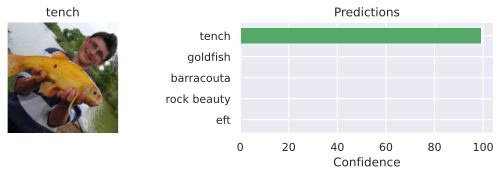

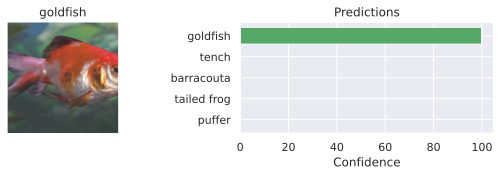

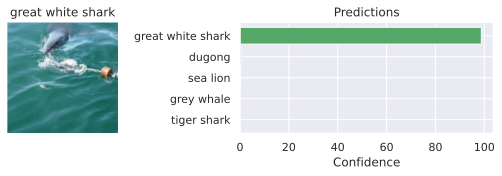

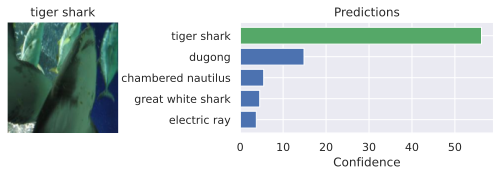

In [9]:
exmp_batch, label_batch = next(iter(data_loader))
with torch.no_grad():
    preds = pretrained_model(exmp_batch.to(device))
for i in range(1,17,5):
    show_prediction(exmp_batch[i], label_batch[i], preds[i])

^ The top 5 predictions are shown on the right in the bar plot. It displays the confidence in predicting that class, or the class probabilities.

Fast Gradient Sign Method (FGSM)

One of the first attack strategies proposed is Fast Gradient Sign Method (FGSM), developed by Ian Goodfellow et al. in 2014. Given an image, we create an adversarial example by the following expression:

𝑥̃=𝑥+𝜖⋅sign(∇𝑥𝐽(𝜃,𝑥,𝑦))

The term  𝐽(𝜃,𝑥,𝑦)  represents the loss of the network for classifying input image  𝑥  as label  𝑦 ;  𝜖  is the intensity of the noise, and  𝑥̃  the final adversarial example. The equation resembles SGD and is actually nothing else than that. We change the input image  𝑥  in the direction of maximizing the loss  𝐽(𝜃,𝑥,𝑦) . This is exactly the other way round as during training, where we try to minimize the loss. The sign function and  𝜖  can be seen as gradient clipping and learning rate specifically. We only allow our attack to change each pixel value by  𝜖 . You can also see that the attack can be performed very fast, as it only requires a single forward and backward pass. Let's implement it below:

In [10]:
def fast_gradient_sign_method(model, imgs, labels, epsilon=0.02):
    # Determine prediction of the model
    inp_imgs = imgs.clone().requires_grad_()
    preds = model(inp_imgs.to(device))
    preds = F.log_softmax(preds, dim=-1)
    # Calculate loss by NLL
    loss = -torch.gather(preds, 1, labels.to(device).unsqueeze(dim=-1))
    loss.sum().backward()
    # Update image to adversarial example as written above
    noise_grad = torch.sign(inp_imgs.grad.to(imgs.device))
    fake_imgs = imgs + epsilon * noise_grad
    fake_imgs.detach_()
    return fake_imgs, noise_grad

The default value of  𝜖=0.02  corresponds to changing a pixel value by about 1 in the range of 0 to 255, e.g. changing 127 to 128. This difference is marginal and can often not be recognized by humans. Let's try it below on our example images:

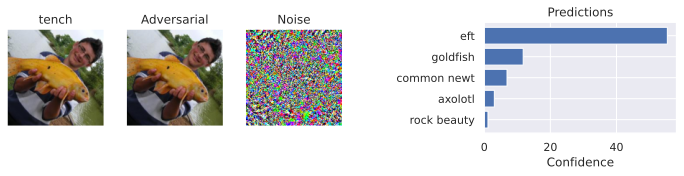

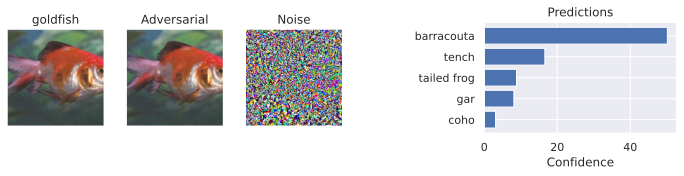

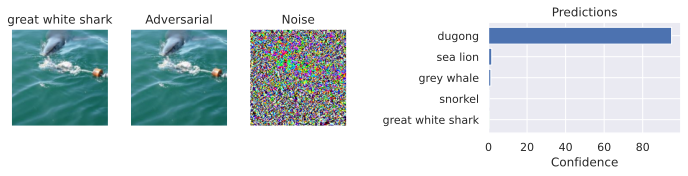

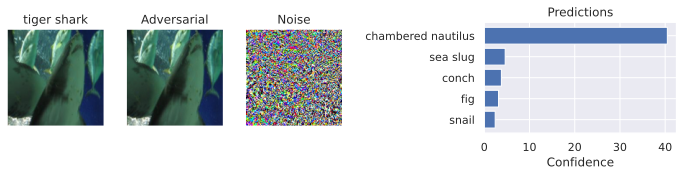

In [11]:
adv_imgs, noise_grad = fast_gradient_sign_method(pretrained_model, exmp_batch, label_batch, epsilon=0.02)
with torch.no_grad():
    adv_preds = pretrained_model(adv_imgs.to(device))

for i in range(1,17,5):
    show_prediction(exmp_batch[i], label_batch[i], adv_preds[i], adv_img=adv_imgs[i], noise=noise_grad[i])

In [12]:
_ = eval_model(data_loader, img_func=lambda x, y: fast_gradient_sign_method(pretrained_model, x, y, epsilon=0.02)[0])

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Top-1 error: 93.74%
Top-5 error: 60.82%


^ All images are fooled with the adversarial image, classifying the image as a totally different class. Here, the predictions are somewhat in the same category though, like both are fish.

Adversarial Patches

Instead of changing every pixel by a little bit, we can also try to change a small part of the image into whatever values we would like. In other words, we will create a small image patch that covers a minor part of the original image but causes the model to confidentially predict a specific class we choose. This form of attack is an even bigger threat in real-world applications than FSGM. Imagine a network in an autonomous car that receives a live image from a camera. Another driver could print out a specific pattern and put it on the back of his/her vehicle to make the autonomous car believe that the car is actually a pedestrian. Meanwhile, humans would not notice it. Tom Brown et al. proposed a way of learning such adversarial image patches robustly in 2017 and provided a short demonstration on YouTube. Interestingly, if you add a small picture of the target class (here toaster) to the original image, the model does not pick it up at all. A specifically designed patch, however, which only roughly looks like a toaster, can change the network's prediction instantaneously.

Let's take a closer look at how we can actually train such patches. The general idea is very similar to FSGM in the sense that we calculate gradients for the input, and update our adversarial input correspondingly. However, there are also some differences in the setup. Firstly, we do not calculate a gradient for every pixel. Instead, we replace parts of the input image with our patch and then calculate the gradients just for our patch. Secondly, we don't just do it for one image, but we want the patch to work with any possible image. Hence, we have a whole training loop where we train the patch using SGD. Lastly, image patches are usually designed to make the model predict a specific class, not just any other arbitrary class except the true label. For instance, we can try to create a patch for the class "toaster" and train the patch so that our pretrained model predicts the class "toaster" for any image with the patch in it.

Additionally, to the setup described above, there are a couple of design choices we can take. For instance, Brown et al. randomly rotated and scaled the patch during training before placing it at a random position in an input image. This makes the patch more robust to small changes and is necessary if we want to fool a neural network in a real-world application. For simplicity, we will only focus on making the patch robust to the location in the image. Given a batch of input images and a patch, we can add the patch as follows:

In [13]:
def place_patch(img, patch):
    for i in range(img.shape[0]):
        h_offset = np.random.randint(0,img.shape[2]-patch.shape[1]-1)
        w_offset = np.random.randint(0,img.shape[3]-patch.shape[2]-1)
        img[i,:,h_offset:h_offset+patch.shape[1],w_offset:w_offset+patch.shape[2]] = patch_forward(patch)
    return img

The patch itself will be an nn.Parameter whose values are in the range between  −∞  and  ∞ . Images are, however, naturally limited in their range, and thus we write a small function that maps the parameter into the image value range of ImageNet:

In [14]:
TENSOR_MEANS, TENSOR_STD = torch.FloatTensor(NORM_MEAN)[:,None,None], torch.FloatTensor(NORM_STD)[:,None,None]
def patch_forward(patch):
    # Map patch values from [-infty,infty] to ImageNet min and max
    patch = (torch.tanh(patch) + 1 - 2 * TENSOR_MEANS) / (2 * TENSOR_STD)
    return patch

We evaluate the success of a patch by how many times we were able to fool the network into predicting our target class. A simple function for this is implemented below.

In [15]:
def eval_patch(model, patch, val_loader, target_class):
    model.eval()
    tp, tp_5, counter = 0., 0., 0.
    with torch.no_grad():
        for img, img_labels in tqdm(val_loader, desc="Validating...", leave=False):
            # For stability, place the patch at 4 random locations per image, and average the performance
            for _ in range(4):
                patch_img = place_patch(img, patch)
                patch_img = patch_img.to(device)
                img_labels = img_labels.to(device)
                pred = model(patch_img)
                # In the accuracy calculation, we need to exclude the images that are of our target class
                # as we would not "fool" the model into predicting those
                tp += torch.logical_and(pred.argmax(dim=-1) == target_class, img_labels != target_class).sum()
                tp_5 += torch.logical_and((pred.topk(5, dim=-1)[1] == target_class).any(dim=-1), img_labels != target_class).sum()
                counter += (img_labels != target_class).sum()
    acc = tp/counter
    top5 = tp_5/counter
    return acc, top5

Finally, we can look at the training loop. Given a model to fool, a target class to design the patch for, and a size  𝑘  of the patch in the number of pixels, we first start by creating a parameter of size  3×𝑘×𝑘 . These are the only parameters we will train, and the network itself remains untouched. We use a simple SGD optimizer with momentum to minimize the classification loss of the model given the patch in the image. While we first start with a very high loss due to the good initial performance of the network, the loss quickly decreases once we start changing the patch. In the end, the patch will represent patterns that are characteristic of the class. For instance, if we would want the model to predict a "goldfish" in every image, we would expect the pattern to look somewhat like a goldfish. Over the iterations, the model finetunes the pattern and, hopefully, achieves a high fooling accuracy.

In [16]:
def patch_attack(model, target_class, patch_size=64, num_epochs=5):
    # Leave a small set of images out to check generalization
    # In most of our experiments, the performance on the hold-out data points
    # was as good as on the training set. Overfitting was little possible due
    # to the small size of the patches.
    train_set, val_set = torch.utils.data.random_split(dataset, [4500, 500])
    train_loader = data.DataLoader(train_set, batch_size=32, shuffle=True, drop_last=True, num_workers=8)
    val_loader = data.DataLoader(val_set, batch_size=32, shuffle=False, drop_last=False, num_workers=4)

    # Create parameter and optimizer
    if not isinstance(patch_size, tuple):
        patch_size = (patch_size, patch_size)
    patch = nn.Parameter(torch.zeros(3, patch_size[0], patch_size[1]), requires_grad=True)
    optimizer = torch.optim.SGD([patch], lr=1e-1, momentum=0.8)
    loss_module = nn.CrossEntropyLoss()

    # Training loop
    for epoch in range(num_epochs):
        t = tqdm(train_loader, leave=False)
        for img, _ in t:
            img = place_patch(img, patch)
            img = img.to(device)
            pred = model(img)
            labels = torch.zeros(img.shape[0], device=pred.device, dtype=torch.long).fill_(target_class)
            loss = loss_module(pred, labels)
            optimizer.zero_grad()
            loss.mean().backward()
            optimizer.step()
            t.set_description(f"Epoch {epoch}, Loss: {loss.item():4.2f}")

    # Final validation
    acc, top5 = eval_patch(model, patch, val_loader, target_class)

    return patch.data, {"acc": acc.item(), "top5": top5.item()}

Can load pretrained patches.
But if training a new class, then there is a function to save its results.

In [17]:
# Load evaluation results of the pretrained patches
json_results_file = os.path.join(CHECKPOINT_PATH, "patch_results.json")
json_results = {}
if os.path.isfile(json_results_file):
    with open(json_results_file, "r") as f:
        json_results = json.load(f)

# If you train new patches, you can save the results via calling this function
def save_results(patch_dict):
    result_dict = {cname: {psize: [t.item() if isinstance(t, torch.Tensor) else t
                                   for t in patch_dict[cname][psize]["results"]]
                           for psize in patch_dict[cname]}
                   for cname in patch_dict}
    with open(os.path.join(CHECKPOINT_PATH, "patch_results.json"), "w") as f:
        json.dump(result_dict, f, indent=4)

We implemented a function to train and evaluate patches for a list of classes and patch sizes.
We trained each class for three different patch sizes:  32×32  pixels,  48×48  pixels, and  64×64  pixels. We can load them in the two cells below.

In [18]:
def get_patches(class_names, patch_sizes):
    result_dict = dict()

    # Loop over all classes and patch sizes
    for name in class_names:
        result_dict[name] = dict()
        for patch_size in patch_sizes:
            c = label_names.index(name)
            file_name = os.path.join(CHECKPOINT_PATH, f"{name}_{patch_size}_patch.pt")
            # Load patch if pretrained file exists, otherwise start training
            if not os.path.isfile(file_name):
                patch, val_results = patch_attack(pretrained_model, target_class=c, patch_size=patch_size, num_epochs=5)
                print(f"Validation results for {name} and {patch_size}:", val_results)
                torch.save(patch, file_name)
            else:
                patch = torch.load(file_name)
            # Load evaluation results if exist, otherwise manually evaluate the patch
            if name in json_results:
                results = json_results[name][str(patch_size)]
            else:
                results = eval_patch(pretrained_model, patch, data_loader, target_class=c)

            # Store results and the patches in a dict for better access
            result_dict[name][patch_size] = {
                "results": results,
                "patch": patch
            }

    return result_dict

I'm training a patch for the class 'king crab' and the rest are pre-trained class patches.

In [19]:
class_names = ['king crab', 'goldfish', 'school bus', 'lipstick', 'pineapple']
patch_sizes = [32, 48, 64]

patch_dict = get_patches(class_names, patch_sizes)
# save_results(patch_dict) # Uncomment if you add new class names and want to save the new results

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/16 [00:00<?, ?it/s]

Validation results for king crab and 32: {'acc': 0.35621243715286255, 'top5': 0.8522043824195862}


Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/16 [00:00<?, ?it/s]

Validation results for king crab and 48: {'acc': 0.9340000152587891, 'top5': 0.9925000071525574}


Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/16 [00:00<?, ?it/s]

Validation results for king crab and 64: {'acc': 0.990981936454773, 'top5': 0.9994990229606628}


Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

In [20]:
save_results(patch_dict)

In [37]:
class_names = ['king crab', 'goldfish', 'school bus', 'lipstick', 'pineapple']

To visualize the patches:

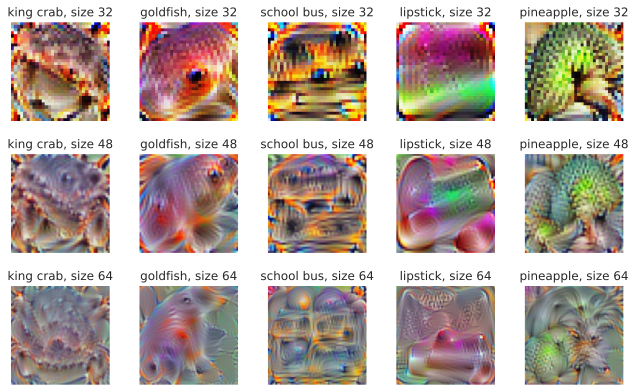

In [38]:
def show_patches():
    fig, ax = plt.subplots(len(patch_sizes), len(class_names), figsize=(len(class_names)*2.2, len(patch_sizes)*2.2))
    for c_idx, cname in enumerate(class_names):
        for p_idx, psize in enumerate(patch_sizes):
            patch = patch_dict[cname][psize]["patch"]
            patch = (torch.tanh(patch) + 1) / 2 # Parameter to pixel values
            patch = patch.cpu().permute(1, 2, 0).numpy()
            patch = np.clip(patch, a_min=0.0, a_max=1.0)
            ax[p_idx][c_idx].imshow(patch)
            ax[p_idx][c_idx].set_title(f"{cname}, size {psize}")
            ax[p_idx][c_idx].axis('off')
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.show()
show_patches()

^ The larger the patch becomes, the more stretched the pattern becomes. For the goldfish, we can still spot regions that might represent eyes and the characteristic orange color, but it is not clearly a single fish anymore. For the pineapple, we might interpret the top part of the image as the leaves of pineapple fruit, but it is more abstract than our small patches. Nevertheless, we can easily spot the alignment of the patch to class, even on the largest scale.

In [22]:
%%html
<!-- Some HTML code to increase font size in the following table -->
<style>
th {font-size: 120%;}
td {font-size: 120%;}
</style>

Quantitative results:

In [23]:
import tabulate
from IPython.display import display, HTML

def show_table(top_1=True):
    i = 0 if top_1 else 1
    table = [[name] + [f"{(100.0 * patch_dict[name][psize]['results'][i]):4.2f}%" for psize in patch_sizes]
             for name in class_names]
    display(HTML(tabulate.tabulate(table, tablefmt='html', headers=["Class name"] + [f"Patch size {psize}x{psize}" for psize in patch_sizes])))

In [24]:
show_table(top_1=True)

In [25]:
show_table(top_1=False)

^ The larger the patch, the more easily it fools the model. So the larger the patch, the higher accuracy is shown for the adversarial class prediction probability. The king crab had an accuracy of < 40% for the smallest patch size, so it was hardest to fool the model with this adversarial patch.

In [26]:
def perform_patch_attack(patch):
    patch_batch = exmp_batch.clone()
    patch_batch = place_patch(patch_batch, patch)
    with torch.no_grad():
        patch_preds = pretrained_model(patch_batch.to(device))
    for i in range(1,17,5):
        show_prediction(patch_batch[i], label_batch[i], patch_preds[i])

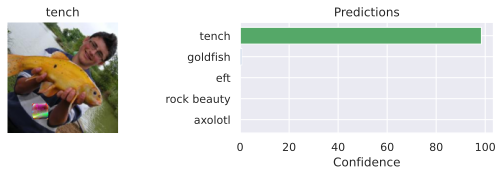

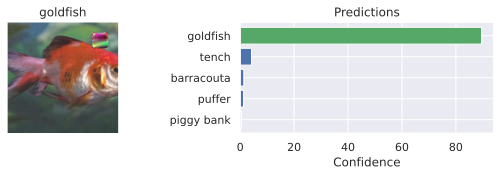

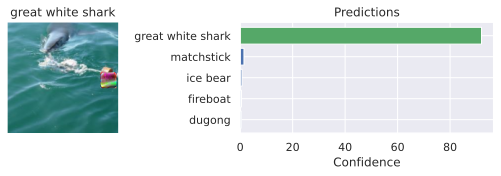

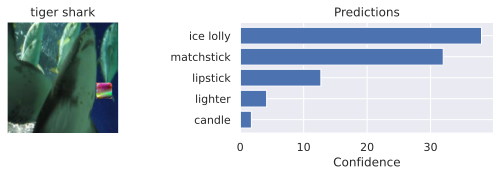

In [27]:
perform_patch_attack(patch_dict['lipstick'][32]['patch'])

^ The smallest lipstick adversarial patch was not able to fool the model, and the model predicted the correct classes. Except for the tiger shark, it was very confused and lipstick was the 3rd most confident prediction.

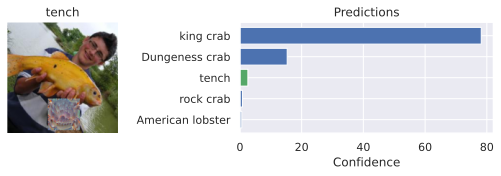

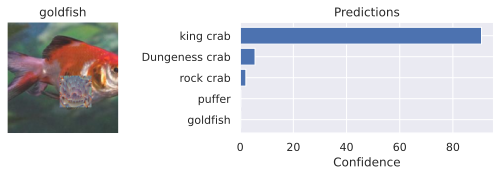

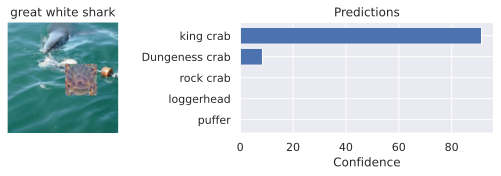

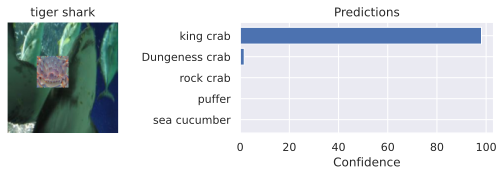

In [28]:
perform_patch_attack(patch_dict['king crab'][64]['patch'])

^ Here the largest tiger shark adversarial patch was able to fool all the image predictions with a probability close to 100%.

In [29]:
transfer_model = torchvision.models.densenet121(weights='IMAGENET1K_V1')
transfer_model = transfer_model.to(device)

# No gradients needed for the network
transfer_model.eval()
for p in transfer_model.parameters():
    p.requires_grad = False

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to ../saved_models/tutorial10/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 188MB/s]


In [30]:
class_name = 'king crab'
patch_size = 64
print(f"Testing patch \"{class_name}\" of size {patch_size}x{patch_size}")

results = eval_patch(transfer_model,
                     patch_dict[class_name][patch_size]["patch"],
                     data_loader,
                     target_class=label_names.index(class_name))

print(f"Top-1 fool accuracy: {(results[0] * 100.0):4.2f}%")
print(f"Top-5 fool accuracy: {(results[1] * 100.0):4.2f}%")

Testing patch "king crab" of size 64x64


Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Top-1 fool accuracy: 69.75%
Top-5 fool accuracy: 87.15%


References

This tutorial was originally created by Phillip Lippe. View notebooks on Github Open In Collab

[1] Goodfellow, Ian J., Jonathon Shlens, and Christian Szegedy. "Explaining and harnessing adversarial examples." ICLR 2015.

[2] Hendrik Metzen, Jan, et al. "Universal adversarial perturbations against semantic image segmentation." Proceedings of the IEEE International Conference on Computer Vision. 2017.

[3] Anant Jain. "Breaking neural networks with adversarial attacks." Blog post 2019.

There was no use of AI in this assignment.